In [55]:
"""
Created on Wed Dec 8 18:44:40 2021
@author: meraidandouch
"""
import numpy as np
import pandas as pd
from scipy.spatial.distance import pdist, squareform
from scipy.spatial import distance
from skbio.stats.ordination import pcoa
import matplotlib.pyplot as plt
import seaborn as sns
np.set_printoptions(precision=3)

In [56]:
def braycurtis(X):
    """
    this function computes Bray-Curtis dissimilarity.
    X: input N x K data matrix. Where N is the number of samples, K is the numbe
    Return: N x N data matrix. The value of (i,j) shows the distance between sam
    """
    dm = []
    for i in range(len(X)):
        temp = []
        for j in range(len(X)):
            temp.append(distance.braycurtis(X[i], X[j]))
            temp = np.array(temp)
            dm.append(temp)
    return np.stack(dm) #dissamilalirty matrix using

def generate_richness(data):
    """
    This function generates the number of OTUs per sample
    and counts the number of reads per sample 
    data: a DataFrame of read counts for each OTU
    return dataframe of OTU richness
    """
    data = (data != 0).astype(int).sum(axis=0)
    data = data[1:-1] #first row is OTU_ID and last row is taxnomy, remove them
    return data

def generate_entropy(x):
    """
    This function calculates the entropy of the freq of distinct sequences
    or in other the words the entropy/uncertainity of distinct sequences 
    x: a list of all the frequencies(porportions) for distinct sequences
    Return NE
    """
    x = x[x != 0.0] #cant take log of 0!
    x = np.array(x, dtype="float64")
    freq = x
    log_freq = np.log(x)
    entropy = -np.sum(freq*log_freq)
    NE = np.exp(entropy)
    return NE

In [57]:
groups = pd.read_csv('baboon_metadata_alpha_diversity.csv') 
data = pd.read_csv('OTU_table.csv', index_col= ['OTU_ID', 'taxonomy'] )
otu_rich = generate_richness(data)
swabs = data.columns
rows, cols = data.shape #12211 rows and 54 cols
groups = groups.iloc[:,:].values
groupings = list(zip(groups[:,0], groups[:,2], groups[:,3], groups[:,4])) 
categ = pd.DataFrame(groupings, columns= ["Sample", "Social", "Rep State", "Ov State"])

In [58]:
#def rarefy_cumsum(x, depth):
#    # Get cumulative sums
#    cumsum = x.cumsum()
#    # Normalize to the maximum count if above the depth
#   if cumsum.iloc[-1] > depth:
#        cumsum = cumsum / cumsum.iloc[-1] * depth
#    return cumsum

# Apply the rarefaction
#rarefied_counts = data.apply(lambda x: rarefy_cumsum(x, 1777373), axis=1)

#data = rarefied_counts

In [59]:
# Normalize Data for Beta Diversity 
cumsum_df = data.cumsum(axis=0)
p = 0.3144699  # From metagenomeSeq package in R 
data = data.div(cumsum_df.quantile(p), axis=1)

In [60]:
#1: create a phylum dict with total read counts for each sample
# key is the phyla and the total read count for phyla 
master_phylum = {}
for i in range(len(data)):
    last_col = data.index[i][-1]   #last col is phyla description
    phyla = last_col.split(';')
    phyla = ";".join(phyla[0:2]) # semi-colon delimiter, look at just up to phylum, don't want class
    if phyla in master_phylum.keys():
        master_phylum[phyla] = np.sum([master_phylum[phyla], data.iloc[i, :]], axis =0)
    else:
        master_phylum[phyla] = data.iloc[i, :]

In [61]:
count = pd.DataFrame(master_phylum) 
countmi = categ.merge(count, left_on="Sample", right_index= True, how = 'left' )
countmi.head()

,Sample,Social,Rep State,Ov State,k__Bacteria;p__Fusobacteria,k__Bacteria,k__Bacteria;p__Bacteroidetes,k__Bacteria;p__Firmicutes,k__Bacteria;p__Gemmatimonadetes,k__Bacteria;p__Actinobacteria,...,k__Bacteria;p__Lentisphaerae,k__Bacteria;p__WPS-2,k__Bacteria;p__TM7,k__Bacteria;p__[Thermi],k__Archaea;p__Crenarchaeota,k__Archaea,k__Bacteria;p__Synergistetes,Unclassified,k__Bacteria;p__BRC1,k__Bacteria;p__Chlorobi
0,V01,D,Ovarian Cycling,Swelling,0.294533,0.412617,0.079454,0.152187,0.000001,0.059487,...,0.000000,1.536442e-07,0.000289,0.000000,0.000000,0.000000,0.0,1.536442e-07,0.000000,0.0
1,V02,A,Postpartum Amenorrhea,NaN,0.003816,0.175764,0.104400,0.450616,0.001202,0.117053,...,0.001457,2.691194e-03,0.000043,0.000114,0.000128,0.000029,0.0,1.519590e-06,0.000001,0.0
2,V03,B,Ovarian Cycling,Swelling,0.127057,0.042434,0.078287,0.153865,0.000004,0.593840,...,0.000000,2.101271e-05,0.000012,0.000002,0.000000,0.000000,0.0,0.000000e+00,0.000000,0.0
3,V04,D,Pregnant,NaN,0.623723,0.094443,0.035034,0.104726,0.000271,0.019620,...,0.000000,0.000000e+00,0.000002,0.000005,0.000075,0.000000,0.0,3.044003e-07,0.000000,0.0
4,V05,B,Ovarian Cycling,Deturgescence,0.105631,0.008520,0.008126,0.039382,0.000004,0.011257,...,0.001955,2.275725e-04,0.000009,0.000000,0.000000,0.000000,0.0,0.000000e+00,0.000000,0.0


In [62]:
#out richness matrix
otu_rich = pd.DataFrame(otu_rich, columns=['OTU_Rich'])
otu_rich = categ.merge(otu_rich, left_on="Sample", right_index= True, how = 'left' )
otu_rich.set_index(['Sample', 'Social', 'Rep State', 'Ov State'], inplace=True)
otu_rich.head()

,,,,OTU_Rich
Sample,Social,Rep State,Ov State,
V01,D,Ovarian Cycling,Swelling,3089.0
V02,A,Postpartum Amenorrhea,NaN,3149.0
V03,B,Ovarian Cycling,Swelling,2364.0
V04,D,Pregnant,NaN,3416.0
V05,B,Ovarian Cycling,Deturgescence,1475.0


In [63]:
#2: get porportion for each sample per phylum
values = countmi.iloc[:,4:]
total = values.sum(axis=1) #sum row to get sample read count total
overall_total = total.sum()
freq = pd.DataFrame(columns = values.columns)
for i in range(len(countmi)):
    temp = (countmi.iloc[i,4:].values / total[i]) #relative abundance
    freq.loc[i] = temp
    #print(freq.loc[i])
freq.index = countmi.Sample
freq = categ.merge(freq, left_on="Sample", right_index=True, how = 'left' )
freq.set_index(['Sample', 'Social', 'Rep State', 'Ov State'], inplace=True)
freq.head()

,,,,k__Bacteria;p__Fusobacteria,k__Bacteria,k__Bacteria;p__Bacteroidetes,k__Bacteria;p__Firmicutes,k__Bacteria;p__Gemmatimonadetes,k__Bacteria;p__Actinobacteria,k__Bacteria;p__Proteobacteria,k__Bacteria;p__Spirochaetes,k__Bacteria;p__Verrucomicrobia,k__Bacteria;p__Cyanobacteria,...,k__Bacteria;p__Lentisphaerae,k__Bacteria;p__WPS-2,k__Bacteria;p__TM7,k__Bacteria;p__[Thermi],k__Archaea;p__Crenarchaeota,k__Archaea,k__Bacteria;p__Synergistetes,Unclassified,k__Bacteria;p__BRC1,k__Bacteria;p__Chlorobi
Sample,Social,Rep State,Ov State,,,,,,,,,,,,,,,,,,,,,
V01,D,Ovarian Cycling,Swelling,0.293117,0.410633,0.079072,0.151455,0.000001,0.059201,0.005363,0.000857,0.000003,0.000001,...,0.0,0.0,0.000287,0.0,0.0,0.0,0.0,0.0,0.0,0.0
V02,A,Postpartum Amenorrhea,NaN,0.003798,0.174923,0.1039,0.448459,0.001196,0.116493,0.086099,0.001806,0.028411,0.000787,...,0.00145,0.002678,0.000043,0.000114,0.000128,0.000028,0.0,0.000002,0.000001,0.0
V03,B,Ovarian Cycling,Swelling,0.126832,0.042359,0.078148,0.153592,0.000004,0.592786,0.004837,0.000061,0.000803,0.000078,...,0.0,0.000021,0.000012,0.000002,0.0,0.0,0.0,0.0,0.0,0.0
V04,D,Pregnant,NaN,0.62184,0.094158,0.034929,0.10441,0.00027,0.019561,0.109029,0.00323,0.000126,0.000022,...,0.0,0.0,0.000002,0.000005,0.000075,0.0,0.0,0.0,0.0,0.0
V05,B,Ovarian Cycling,Deturgescence,0.105433,0.008504,0.00811,0.039308,0.000004,0.011236,0.689941,0.000098,0.000737,0.00005,...,0.001951,0.000227,0.000009,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [64]:
#3: filter out phylum with low abundances
freq_copy = pd.DataFrame()
low_abundance = []
for i in range(len(freq.columns)):
    phyla_mean = np.mean(freq.iloc[:,i])
    col = freq.columns[i]
    if phyla_mean*100 > 1 or col in 'k__Archaea' or col in 'Unclassified' or col in 'k__Bacteria':
        freq_copy[col] = freq.iloc[:,i]
    else: #Phyla present at <1% are grouped into the category “Low abundance Ba
        low_abundance.append(freq.iloc[:,i].values) #collect all low abundance d
low_abundance = np.array(low_abundance)
low_abundance = np.sum(low_abundance, axis = 0) #sum up low abundance data
freq_copy["low abundance"] = low_abundance
#relative abundance matrix
dfmi = freq_copy.copy()
dfmi.index = pd.MultiIndex.from_tuples(groupings, names= ["Sample", "Social", "Rep State", "Ov State"])
dfmi.head()

,,,,k__Bacteria;p__Fusobacteria,k__Bacteria,k__Bacteria;p__Bacteroidetes,k__Bacteria;p__Firmicutes,k__Bacteria;p__Actinobacteria,k__Bacteria;p__Proteobacteria,k__Bacteria;p__Tenericutes,k__Archaea,Unclassified,low abundance
Sample,Social,Rep State,Ov State,,,,,,,,,,
V01,D,Ovarian Cycling,Swelling,0.293117,0.410633,0.079072,0.151455,0.059201,0.005363,0.000004,0.0,0.0,0.001155
V02,A,Postpartum Amenorrhea,NaN,0.003798,0.174923,0.1039,0.448459,0.116493,0.086099,0.019615,0.000028,0.000002,0.046683
V03,B,Ovarian Cycling,Swelling,0.126832,0.042359,0.078148,0.153592,0.592786,0.004837,0.000372,0.0,0.0,0.001075
V04,D,Pregnant,NaN,0.62184,0.094158,0.034929,0.10441,0.019561,0.109029,0.010263,0.0,0.0,0.005811
V05,B,Ovarian Cycling,Deturgescence,0.105433,0.008504,0.00811,0.039308,0.011236,0.689941,0.133722,0.0,0.0,0.003745


In [65]:
cat_order = ["Postpartum Amenorrhea", "Anestrus", "Swelling", 'Deturgescence', "Pregnant", "Peri-Ovulation", "Miscarrying"]
bacteria_columns = ['Unclassified', 
              'k__Archaea', 
              'k__Bacteria', 
              'low abundance', 
              'k__Bacteria;p__Tenericutes', 
              'k__Bacteria;p__Actinobacteria',
              'k__Bacteria;p__Bacteroidetes',
              'k__Bacteria;p__Proteobacteria', 
              'k__Bacteria;p__Fusobacteria', 
              'k__Bacteria;p__Firmicutes'
                ]
dfmi_copy = dfmi.copy()
dfmi_copy = dfmi_copy.reset_index()
dfmi_copy['cat'] = dfmi_copy['Ov State'].fillna(dfmi_copy['Rep State'])
custom_dict = {"Postpartum Amenorrhea":0, "Anestrus": 1, "Swelling": 2, "Peri-Ovulation":3, "Deturgescence":4, "Pregnant":5, "Miscarrying":6}
grouped_data = dfmi_copy.groupby(['cat', 'Sample'])[bacteria_columns].mean()
grouped_data = grouped_data.sort_values(by=['cat'], key=lambda x: x.map(custom_dict))
grouped_data.head()

Unclassified k__Archaea k__Bacteria  \
cat                   Sample                                       
Postpartum Amenorrhea V43        0.000001        0.0    0.218217   
                      V52             0.0        0.0    0.052676   
                      V48        0.000001        0.0    0.091381   
                      V47             0.0        0.0    0.128281   
                      V45             0.0        0.0    0.180842   

                             low abundance k__Bacteria;p__Tenericutes  \
cat                   Sample                                            
Postpartum Amenorrhea V43         0.018596                   0.001368   
                      V52         0.002951                   0.000067   
                      V48         0.010312                   0.000919   
                      V47         0.097678                   0.001421   
                      V45         0.010821                    0.00541   

                             k__Bacteria;p__Actinobacteria  \
cat                   Sample                                 
Postpartum Amenorrhea V43                         0.068571   
                      V52                         0.347827   
                      V48                         0.224034   
                      V47                         0.054163   
                      V45                         0.087605   

                             k__Bacteria;p__Bacteroidetes  \
cat                   Sample                                
Postpartum Amenorrhea V43                        0.041208   
                      V52                        0.021559   
                      V48                         0.01389   
                      V47                         0.28276   
                      V45                        0.067447   

                             k__Bacteria;p__Proteobacteria  \
cat                   Sample                                 
Postpartum Amenorrhea V43                         0.103595   
                      V52                         0.024897   
                      V48                         0.039708   
                      V47                         0.036406   
                      V45                         0.053294   

                             k__Bacteria;p__Fusobacteria  \
cat                   Sample                               
Postpartum Amenorrhea V43                       0.151006   
                      V52                       0.000254   
                      V48                       0.137011   
                      V47                        0.01881   
                      V45                       0.119983   

                             k__Bacteria;p__Firmicutes  
cat                   Sample                            
Postpartum Amenorrhea V43                     0.397439  
                      V52                      0.54977  
                      V48                     0.482744  
                      V47                     0.380481  
                      V45                     0.474597

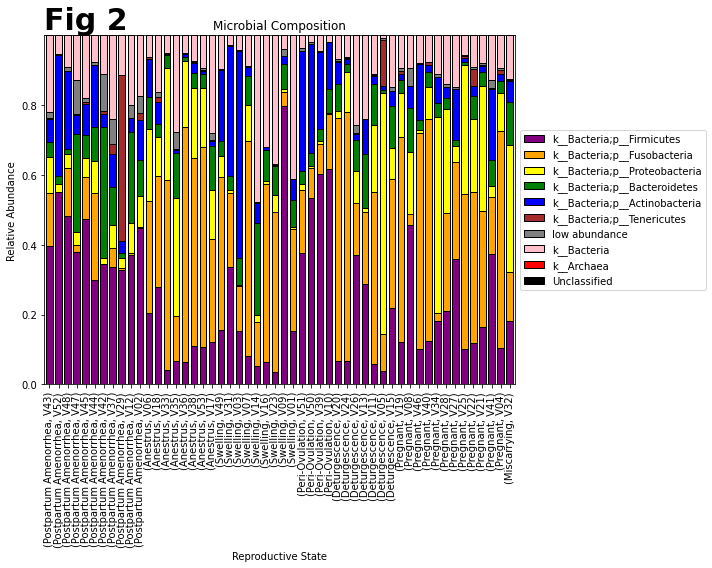

In [66]:
#Anaylsis 1: RELATIVE ABUNDANCE
# Improved Stacked Bar Chart 
color_set = ['black', 'red', 'pink', 'gray', 'brown', 'blue', 'green', 'yellow','orange', 'purple']

ax = grouped_data[bacteria_columns[::-1]].plot(kind='bar', 
                                               stacked=True, 
                                               figsize=(10, 8), 
                                               edgecolor = 'black', 
                                               color=color_set[::-1],
                                               width=0.7,
                                               title='Microbial Composition')
ax.set_title('Fig 2', fontweight='bold', fontsize=30, loc='left')
# Customize the plot
plt.ylabel('Relative Abundance')
plt.xlabel('Reproductive State')
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.tight_layout()
plt.savefig("Fig1.pdf")

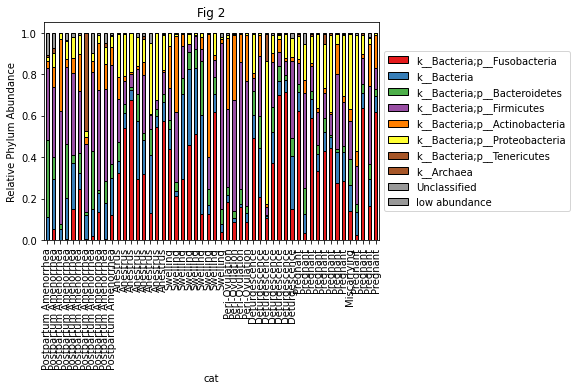

In [67]:
#Anaylsis 1: RELATIVE ABUNDANCE
dfmi_r = dfmi.reset_index()
dfmi_r['cat'] = dfmi_r['Ov State'].fillna(dfmi_r['Rep State'])
custom_dict = {"Postpartum Amenorrhea":0, "Anestrus": 1, "Swelling": 2, "Peri-Ovulation": 3, "Deturgescence": 4 }
dfmi_r = dfmi_r.sort_values(by=['cat'], key=lambda x: x.map(custom_dict))
dfmi_r.plot(x='cat',
kind='bar',
stacked=True,
title='Fig 2', colormap='Set1', edgecolor = 'black')
plt.ylabel("Relative Phylum Abundance")
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.savefig("Fig1_do_not_use.pdf")

In [68]:
#Anaylsis 2:ALPHA DIVERSITY Shannon's Diversity Index 
alpha = []
for i in range(len(freq)):
    alpha.append(generate_entropy(freq.iloc[i,:].values))
alpha = pd.DataFrame(alpha, columns=["Shannon's Diversity Index"])
alpha.index = pd.MultiIndex.from_tuples(groupings, names=["ID", "Social", "Rep St", "Ov St"])
alpha.head()

,,,,Shannon's Diversity Index
ID,Social,Rep St,Ov St,
V01,D,Ovarian Cycling,Swelling,1.849317
V02,A,Postpartum Amenorrhea,NaN,2.071762
V03,B,Ovarian Cycling,Swelling,1.706004
V04,D,Pregnant,NaN,1.739011
V05,B,Ovarian Cycling,Deturgescence,1.575138


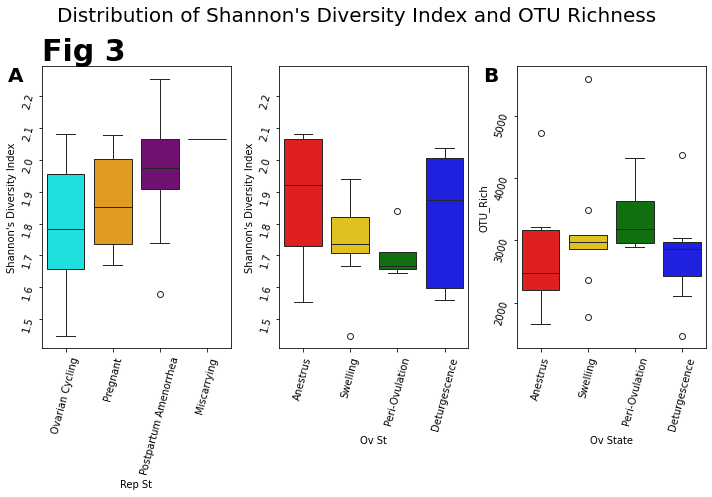

In [69]:
# ALPHA DIVERSITY GRAPHS
alpha_ov = alpha.copy()
otu_rich_copy = otu_rich
#alpha = alpha.loc[:, :,["Pregnant", "Ovarian Cycling", "Postpartum Amenorrhea"]]
figa, axes = plt.subplots(1, 3, figsize=(10,7), sharey='col')
figa.suptitle("Distribution of Shannon's Diversity Index and OTU Richness", fontsize=20)
axes[0].set_title('Fig 3', fontweight='bold', fontsize=30, loc='left')

# Plot for Reproductive State
reproductive_state_palette = {
    'Ovarian Cycling': 'cyan',
    'Pregnant': 'orange',
    'Postpartum Amenorrhea': 'purple',
    'Miscarrying': 'navy',
}

cycle_phase_palette = {
    "Anestrus": 'red',
    'Swelling': 'gold',
    'Peri-Ovulation': 'green',
    'Deturgescence': 'blue',
}
palette = sns.color_palette("deep")

sns.boxplot(
    ax = axes[0], 
    x="Rep St", y ="Shannon's Diversity Index", 
    data=alpha,
    palette=reproductive_state_palette, 
    hue="Rep St",        
    order= reproductive_state_palette,
    dodge=False,  
    legend=False  
)

sns.boxplot(
    ax = axes[1], 
    x="Ov St", y ="Shannon's Diversity Index", 
    data=alpha,
    palette=cycle_phase_palette, 
    hue="Ov St",        
    order= cycle_phase_palette,
    dodge=False,  
    legend=False  
)
axes[0].text(-0.1, 1.0, 'A', transform=axes[0].transAxes,fontsize=20, fontweight='bold', va='top', ha='right')


sns.boxplot(
    ax =axes[2], 
    x ="Ov State", y = "OTU_Rich", 
    data = otu_rich,        
    palette = cycle_phase_palette,
    hue="Ov State", 
    order= cycle_phase_palette,
    dodge =False,  
    legend =False  
    )
axes[1].sharey(axes[0])
axes[2].text(-0.1, 1.0, 'B', transform=axes[2].transAxes,fontsize=20, fontweight='bold', va='top', ha='right')


for ax in axes: 
    ax.tick_params(rotation=75)
plt.tight_layout()
plt.savefig("Fig3.pdf")

In [41]:
# Analysis 3: BETA DIVERSITY
#relative abundance ovarian state
ov_state = dfmi.loc[:, :, :, ["Swelling", "Deturgescence", "Peri-Ovulation", "Anestrus"]]
dfmi = dfmi.apply(pd.to_numeric, errors='coerce')
count = count.apply(pd.to_numeric, errors='coerce')
ov_state = ov_state.apply(pd.to_numeric, errors='coerce')
dfmi_copy = dfmi.values
count_copy = count.values
ov_state_copy = ov_state.values
dm = pdist(dfmi_copy, metric = 'braycurtis') #all samples
dm = squareform(dm)
dm_ov = pdist(ov_state_copy, metric = 'braycurtis') #only ovarian state samples
dm_ov = squareform(dm_ov)
print(dm.shape, dm_ov.shape)
bc_PCoA = pcoa(dm)
variance = bc_PCoA.proportion_explained
X_pcoa = bc_PCoA.samples
X_pcoa = np.array(X_pcoa)
ov_bc_PCoA = pcoa(dm_ov)
ov_variance = ov_bc_PCoA.proportion_explained
X_ov_pcoa = ov_bc_PCoA.samples
X_ov_pcoa = np.array(X_ov_pcoa)

(52, 52) (28, 28)


/opt/anaconda3/lib/python3.8/site-packages/skbio/stats/ordination/_principal_coordinate_analysis.py:143: RuntimeWarning: The result contains negative eigenvalues. Please compare their magnitude with the magnitude of some of the largest positive eigenvalues. If the negative ones are smaller, it's probably safe to ignore them, but if they are large in magnitude, the results won't be useful. See the Notes section for more details. The smallest eigenvalue is -0.17963201718211325 and the largest is 3.4142467300168766.
  warn(
/opt/anaconda3/lib/python3.8/site-packages/skbio/stats/ordination/_principal_coordinate_analysis.py:143: RuntimeWarning: The result contains negative eigenvalues. Please compare their magnitude with the magnitude of some of the largest positive eigenvalues. If the negative ones are smaller, it's probably safe to ignore them, but if they are large in magnitude, the results won't be useful. See the Notes section for more details. The smallest eigenvalue is -0.10653245784

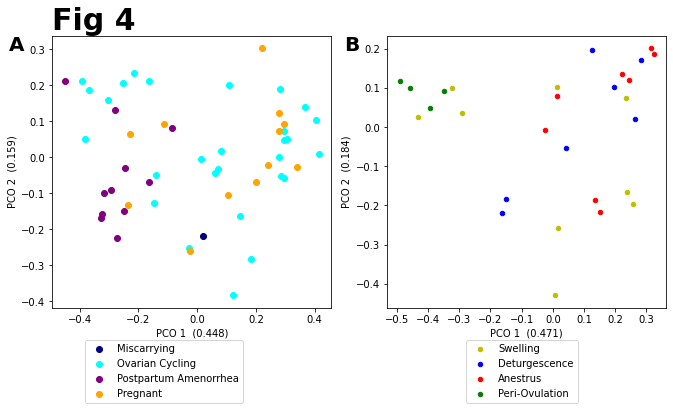

In [42]:
#BETA DIVERSITY GRAPHS 
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(11,5))
ax1.set_title('Fig 4', fontweight='bold', fontsize=30, loc='left')
varianceX = np.around(variance[0],3) 
varianceY = np.around(variance[1], 3)
ax1.set_xlabel("PCO 1  (" +  str(varianceX) + ")")
ax1.set_ylabel("PCO 2  ("   +  str(varianceY) + ")")
my_labels = ['Miscarrying', 'Ovarian Cycling', 'Postpartum Amenorrhea','Pregnant']
colors = ['navy', 'aqua', 'purple', 'orange']
X = pd.DataFrame(X_pcoa)
X.index = pd.MultiIndex.from_tuples(dfmi.index, names=["ID", "Social", "Rep State", "Ov State"])
ax1.scatter(X.loc[:, :, ["Miscarrying"]].iloc[:,0], X.loc[:, :, ["Miscarrying"]].iloc[:,1], marker='o', color = colors[0],  label=my_labels[0])
ax1.scatter(X.loc[:, :, ["Ovarian Cycling"]].iloc[:,0], X.loc[:, :, ["Ovarian Cycling"]].iloc[:,1], marker='o', color = colors[1],  label=my_labels[1])
ax1.scatter(X.loc[:, :, ["Postpartum Amenorrhea"]].iloc[:,0], X.loc[:, :, ["Postpartum Amenorrhea"]].iloc[:,1], marker='o', color = colors[2],  label= my_labels[2])
ax1.scatter(X.loc[:, :, ["Pregnant"]].iloc[:,0], X.loc[:, :, ["Pregnant"]].iloc[:,1], marker='o', color = colors[3],  label=my_labels[3])
ax1.legend(my_labels)
ax1.text(-0.1, 1.0, 'A', transform=ax1.transAxes,fontsize=20, fontweight='bold', va='top', ha='right')

ovarianceX = np.around(ov_variance[0],3) 
ovarianceY = np.around(ov_variance[1], 3)
ax2.set_xlabel("PCO 1  (" +  str(ovarianceX) + ")")
ax2.set_ylabel("PCO 2  ("   +  str(ovarianceY) + ")")
my_labels = ['Swelling', 'Deturgescence', 'Anestrus','Peri-Ovulation']
colors = ['y', 'b', 'r', 'g']
ov = pd.DataFrame(X_ov_pcoa)
ov.index = pd.MultiIndex.from_tuples(ov_state.index, names=["ID", "Social", "Rep State", "Ov State"])
ax2.scatter(ov.loc[:, :, :, ["Swelling"]].iloc[:,0], ov.loc[:, :, :, ["Swelling"]].iloc[:,1], marker='o', s = 20, color = colors[0], label=my_labels[0])
ax2.scatter(ov.loc[:, :, :, ["Deturgescence"]].iloc[:,0], ov.loc[:, :, :, ["Deturgescence"]].iloc[:,1], marker='o', s = 20, color = colors[1],  label=my_labels[1])
ax2.scatter(ov.loc[:, :, :, ["Anestrus"]].iloc[:,0], ov.loc[:, :, :, ["Anestrus"]].iloc[:,1], marker='o', s = 20, color = colors[2],  label=my_labels[2])
ax2.scatter(ov.loc[:, :, :, ["Peri-Ovulation"]].iloc[:,0], ov.loc[:, :, :, ["Peri-Ovulation"]].iloc[:,1], marker='o', s = 20, color = colors[3],  label=my_labels[3])
ax2.legend(my_labels)
ax2.text(-0.1, 1.0, 'B', transform=ax2.transAxes,fontsize=20, fontweight='bold', va='top', ha='right')

ax1.legend(bbox_to_anchor=(0.7, -.10))
ax2.legend(bbox_to_anchor=(0.7, -.10))
plt.savefig("Fig4.pdf")
plt.show()